In [1]:
import sys
print(sys.executable)

C:\Users\MSC1\anaconda3\envs\Env-7144COMP\python.exe


# Data Pre-processing and TFRecord Generation
The purpose of this notebook is to carry out all the required preprocessing tasks for a wildlife object detection task using the Sub-Saharan Africa dataset. The goal of developing these object detection models will be to identify three wildlife species that are ecologically relevant to support wildlife monitoring and conservation efforts.
## Dataset Overview
**Source:** Sub-Saharan wildlife camera trap dataset,
**Total Images:** 1,536 annotated images,
**Annotation Format:** Pascal VOC XML,
**Task:** Multi-class object detection for wildlife species identification
### Selected Species
1. **Oryx Gazella (Gemsbok)** - 504 images
2. **Panthera Leo (Lion)** - 525 images  
3. **Phacochoerus Africanus (Warthog)** - 661 images
### Selection Rationale

**Ecological Relevance:** The three species represent distinct trophic levels (herbivore, omnivore, apex predator) and serve as ecological indicators for habitat quality and ecosystem health.

**Visual Distinctions:**
- **Oryx:** Long straight horns, light gray coat, tall stature
- **Lion:** Tawny fur, manes (males), low crouching posture
- **Warthog:** Facial warts, tusks, compact low-profile body

**Practical Considerations:** All species exceed the 500-image minimum (504-661 images) with acceptable class balance (1.31:1 ratio). These are commonly encountered species in Sub-Saharan monitoring, ensuring real-world applicability.

**Detection Challenges:** Variable lighting conditions, partial occlusions, scale variation (distance from camera), and diverse poses (standing, lying, walking) introduce realistic complexity for model robustness testing.

## Image Annotation Process

Images were annotated using **LabelImg v1.8.6** (Pascal VOC XML format) for compatibility with the TensorFlow Object Detection API. Bounding boxes were drawn tightly around visible animal bodies, with partially occluded animals annotated when >50% visible. Multiple instances per image were annotated individually. Quality control was performed on a random sample to ensure consistency. 

In [2]:
from IPython.display import HTML
HTML("""
<style>
/* Wrap long code and outputs */
pre, code { 
  white-space: pre-wrap !important;
  word-wrap: break-word !important;
}

/* Extra: make code smaller only when printing */
@media print {
  pre, code { font-size: 9pt !important; }
}
</style>
""")

## Set dataset paths
In this section, the required directories for images, annotations, scripts, and outputs are defined to keep the preprocessing process consistent.

In [3]:
import os

IMAGES_DIR = r"C:\Users\MSC1\Desktop\Tensorflow-Object-Detection-API\Base\v1\Tagging\Public\imageproject\dataset"
ANNOTATIONS_DIR = r"C:\Users\MSC1\Desktop\Tensorflow-Object-Detection-API\Base\v1\Tagging\Public\imageproject\label\detection"

# for Safety check to prevent failures
if not os.path.exists(IMAGES_DIR):
    raise ValueError(f"Images directory not found: {IMAGES_DIR}")

if not os.path.exists(ANNOTATIONS_DIR):
    raise ValueError(f"Annotations directory not found: {ANNOTATIONS_DIR}")

print("Images folder exists:", os.path.exists(IMAGES_DIR))
print("Annotations folder exists:", os.path.exists(ANNOTATIONS_DIR))

# Dataset size verification
print(f"Total images: {len([f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))])}")
print(f"Total XMLs: {len([f for f in os.listdir(ANNOTATIONS_DIR) if f.endswith('.xml')])}")

Images folder exists: True
Annotations folder exists: True
Total images: 1536
Total XMLs: 1690


The following libraries are used throughout this notebook: `os`, `shutil`,
`xml.etree.ElementTree`, `random`, `numpy`, and `matplotlib`.

## Class Distribution Analysis
This section analyses the annotated dataset to verify that each selected animal
class meets the minimum requirement of 500 images per class. The XML annotation
files are parsed to count the number of unique images containing each class.

In [4]:
import xml.etree.ElementTree as ET
from collections import defaultdict

image_count_per_class = defaultdict(set)

for xml_file in os.listdir(ANNOTATIONS_DIR):
    if not xml_file.endswith(".xml"):
        continue

    tree = ET.parse(os.path.join(ANNOTATIONS_DIR, xml_file))
    root = tree.getroot()

    filename_node = root.find("filename")
    image_name = filename_node.text if filename_node is not None else xml_file.replace(".xml", "")

    for obj in root.findall("object"):
        class_name = obj.find("name").text.strip()
        image_count_per_class[class_name].add(image_name)

image_count_per_class = {k: len(v) for k, v in image_count_per_class.items()}
image_count_per_class


{'OryxGazella': 504, 'PantheraLeo': 525, 'PhacochoerusAfricanus': 661}

In [5]:
import pandas as pd

class_stats = {}
for class_name in image_count_per_class.keys():
    bbox_count = 0
    images_with_multiple = 0
    
    for xml_file in os.listdir(ANNOTATIONS_DIR):
        if not xml_file.endswith(".xml"):
            continue
        tree = ET.parse(os.path.join(ANNOTATIONS_DIR, xml_file))
        root = tree.getroot()
        
        class_bbox_count_in_image = 0
        for obj in root.findall("object"):
            if obj.find("name").text.strip() == class_name:
                bbox_count += 1
                class_bbox_count_in_image += 1
        
        if class_bbox_count_in_image > 1:
            images_with_multiple += 1
    
    class_stats[class_name] = {
        'images': image_count_per_class[class_name],
        'total_bboxes': bbox_count,
        'avg_bboxes_per_image': round(bbox_count / image_count_per_class[class_name], 2),
        'images_with_multiple_instances': images_with_multiple
    }

stats_df = pd.DataFrame(class_stats).T
print("DETAILED CLASS STATISTICS")
print("="*70)
print(stats_df.to_string())

DETAILED CLASS STATISTICS
                       images  total_bboxes  avg_bboxes_per_image  images_with_multiple_instances
OryxGazella             504.0         591.0                  1.17                            66.0
PantheraLeo             525.0         748.0                  1.42                           148.0
PhacochoerusAfricanus   661.0         743.0                  1.12                            80.0


### Class Distribution Analysis

The dataset shows acceptable balance (1.31:1 ratio, well below the 3:1 threshold for imbalance). All species exceed the 500-image requirement. Multiple instances per image (avg: 1.12-1.42 objects/image) provide training examples for multi-object detection scenarios common in wildlife monitoring.

## Visualisation of Class Distribution

A bar and pie chart is used to visualise the distribution of annotated images across
the three selected animal classes.

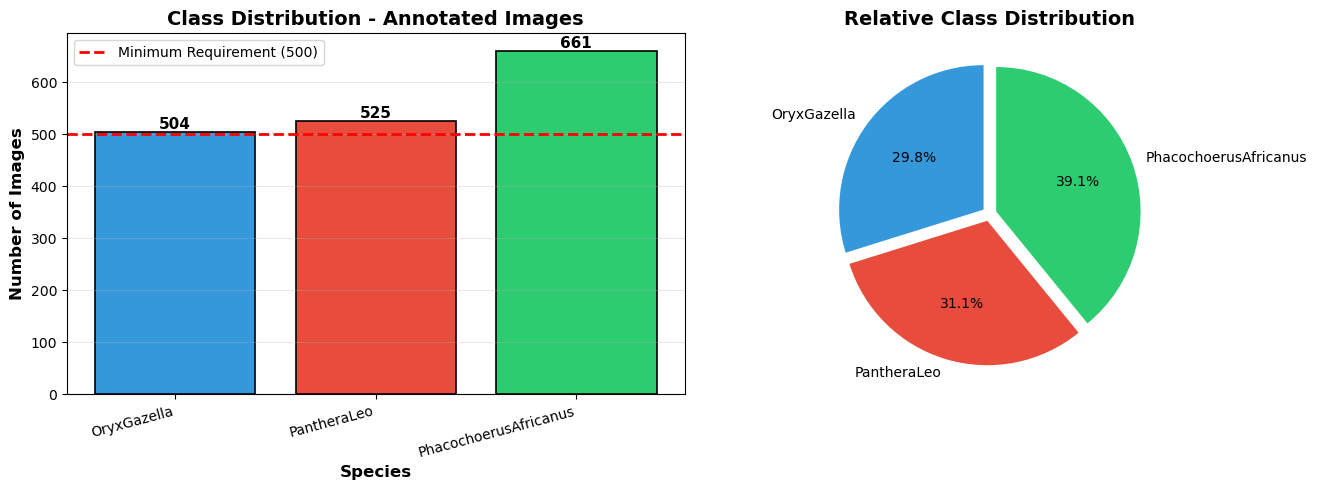

CLASS BALANCE ASSESSMENT
Imbalance Ratio: 1.31:1
Assessment: ACCEPTABLE (< 3:1)


In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

classes = list(image_count_per_class.keys())
counts = list(image_count_per_class.values())

bars = axes[0].bar(classes, counts, color=['#3498db', '#e74c3c', '#2ecc71'], 
                   edgecolor='black', linewidth=1.2)
axes[0].set_xlabel("Species", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Number of Images", fontsize=12, fontweight='bold')
axes[0].set_title("Class Distribution - Annotated Images", fontsize=14, fontweight='bold')
plt.setp(axes[0].get_xticklabels(), rotation=15, ha='right')
axes[0].axhline(y=500, color='red', linestyle='--', linewidth=2, 
                label='Minimum Requirement (500)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Adding value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Percentage comparison
total = sum(counts)
percentages = [(c/total)*100 for c in counts]

axes[1].pie(percentages, labels=classes, autopct='%1.1f%%', startangle=90,
           colors=['#3498db', '#e74c3c', '#2ecc71'], explode=(0.05, 0.05, 0.05))
axes[1].set_title("Relative Class Distribution", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# statistics
print("CLASS BALANCE ASSESSMENT")
print("="*60)
max_class = max(counts)
min_class = min(counts)
imbalance_ratio = max_class / min_class
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Assessment: {'ACCEPTABLE (< 3:1)' if imbalance_ratio < 3 else 'MODERATE IMBALANCE'}")
print("="*60)

## Comprehensive Bounding Box Analysis

In [7]:
# Comprehensive bounding box analysis
import numpy as np

bbox_data = []

for xml_file in os.listdir(ANNOTATIONS_DIR):
    if not xml_file.endswith(".xml"):
        continue
    
    tree = ET.parse(os.path.join(ANNOTATIONS_DIR, xml_file))
    root = tree.getroot()
    
    # Get image dimensions
    size_node = root.find("size")
    if size_node is None:
        continue
        
    img_width = int(size_node.find("width").text)
    img_height = int(size_node.find("height").text)
    
    for obj in root.findall("object"):
        class_name = obj.find("name").text.strip()
        bbox = obj.find("bndbox")
        
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))
        
        # Calculate bbox properties
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin
        bbox_area = bbox_width * bbox_height
        aspect_ratio = bbox_width / bbox_height if bbox_height > 0 else 0
        
        # Relative to image size
        rel_width = bbox_width / img_width
        rel_height = bbox_height / img_height
        rel_area = bbox_area / (img_width * img_height)
        
        bbox_data.append({
            'class': class_name,
            'width': bbox_width,
            'height': bbox_height,
            'area': bbox_area,
            'aspect_ratio': aspect_ratio,
            'rel_width': rel_width,
            'rel_height': rel_height,
            'rel_area': rel_area
        })

bbox_df = pd.DataFrame(bbox_data)

print("\n" + "="*80)
print("BOUNDING BOX ANALYSIS")
print("="*80)

for class_name in sorted(bbox_df['class'].unique()):
    class_bboxes = bbox_df[bbox_df['class'] == class_name]
    print(f"\n{class_name}:")
    print(f"  Total bboxes: {len(class_bboxes)}")
    print(f"  Width  → Mean: {class_bboxes['width'].mean():.1f}px, Std: {class_bboxes['width'].std():.1f}px")
    print(f"           Range: [{class_bboxes['width'].min():.0f}px, {class_bboxes['width'].max():.0f}px]")
    print(f"  Height → Mean: {class_bboxes['height'].mean():.1f}px, Std: {class_bboxes['height'].std():.1f}px")
    print(f"           Range: [{class_bboxes['height'].min():.0f}px, {class_bboxes['height'].max():.0f}px]")
    print(f"  Aspect Ratio → Mean: {class_bboxes['aspect_ratio'].mean():.2f}")
    print(f"                 Range: [{class_bboxes['aspect_ratio'].min():.2f}, {class_bboxes['aspect_ratio'].max():.2f}]")
    print(f"  Relative Size → Mean: {class_bboxes['rel_area'].mean()*100:.1f}% of image area")
    print(f"                  Range: [{class_bboxes['rel_area'].min()*100:.1f}%, {class_bboxes['rel_area'].max()*100:.1f}%]")

print("="*80)


BOUNDING BOX ANALYSIS

OryxGazella:
  Total bboxes: 591
  Width  → Mean: 572.7px, Std: 333.7px
           Range: [139px, 2587px]
  Height → Mean: 707.9px, Std: 405.5px
           Range: [178px, 1956px]
  Aspect Ratio → Mean: 0.86
                 Range: [0.22, 1.65]
  Relative Size → Mean: 9.8% of image area
                  Range: [0.6%, 91.8%]

PantheraLeo:
  Total bboxes: 748
  Width  → Mean: 523.4px, Std: 259.2px
           Range: [78px, 2621px]
  Height → Mean: 392.3px, Std: 220.6px
           Range: [58px, 1723px]
  Aspect Ratio → Mean: 1.49
                 Range: [0.34, 5.46]
  Relative Size → Mean: 32.5% of image area
                  Range: [0.8%, 99.4%]

PhacochoerusAfricanus:
  Total bboxes: 743
  Width  → Mean: 856.0px, Std: 343.4px
           Range: [117px, 2046px]
  Height → Mean: 763.6px, Std: 250.5px
           Range: [152px, 1435px]
  Aspect Ratio → Mean: 1.20
                 Range: [0.16, 3.53]
  Relative Size → Mean: 23.8% of image area
                  Range: 

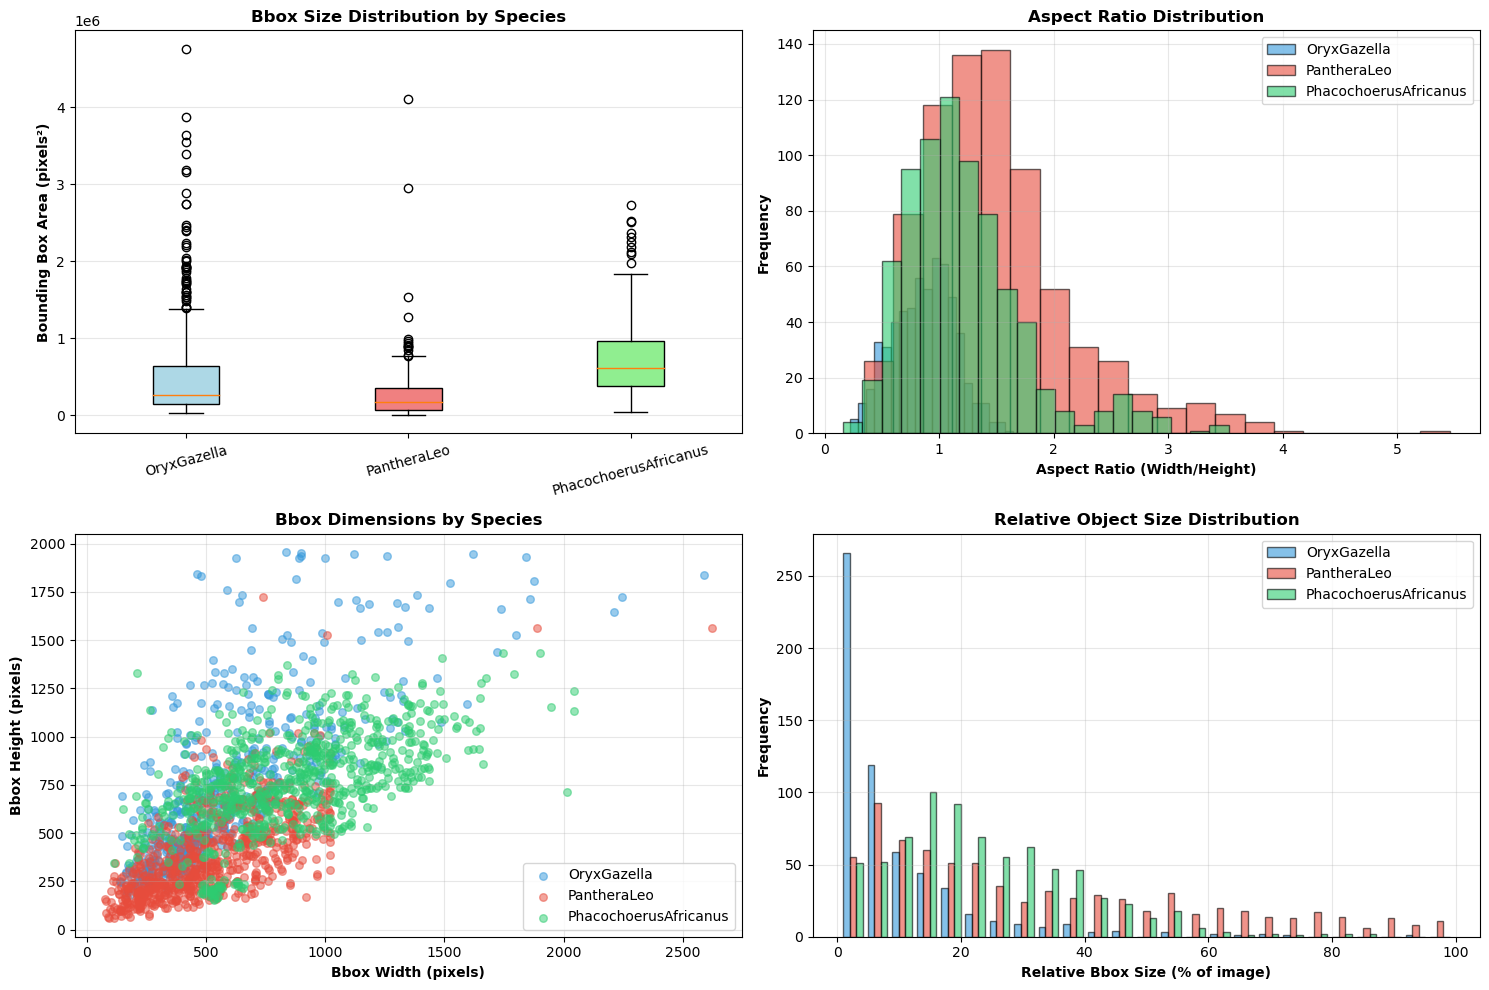

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Bbox size distribution by class
bbox_areas_by_class = [bbox_df[bbox_df['class']==c]['area'].values 
                        for c in sorted(bbox_df['class'].unique())]
bp = axes[0, 0].boxplot(bbox_areas_by_class, labels=sorted(bbox_df['class'].unique()), patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral', 'lightgreen']):
    patch.set_facecolor(color)
axes[0, 0].set_ylabel('Bounding Box Area (pixels²)', fontweight='bold')
axes[0, 0].set_title('Bbox Size Distribution by Species', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=15)

# 2. Aspect ratio distribution
colors = ['#3498db', '#e74c3c', '#2ecc71']
for idx, class_name in enumerate(sorted(bbox_df['class'].unique())):
    class_data = bbox_df[bbox_df['class'] == class_name]
    axes[0, 1].hist(class_data['aspect_ratio'], bins=20, alpha=0.6, 
                    label=class_name, color=colors[idx], edgecolor='black')
axes[0, 1].set_xlabel('Aspect Ratio (Width/Height)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter: width vs height colored by class
for idx, class_name in enumerate(sorted(bbox_df['class'].unique())):
    class_data = bbox_df[bbox_df['class'] == class_name]
    axes[1, 0].scatter(class_data['width'], class_data['height'], 
                       alpha=0.5, label=class_name, s=30, color=colors[idx])
axes[1, 0].set_xlabel('Bbox Width (pixels)', fontweight='bold')
axes[1, 0].set_ylabel('Bbox Height (pixels)', fontweight='bold')
axes[1, 0].set_title('Bbox Dimensions by Species', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Relative size distribution
rel_sizes_by_class = [(bbox_df[bbox_df['class']==c]['rel_area']*100).values 
                       for c in sorted(bbox_df['class'].unique())]
axes[1, 1].hist(rel_sizes_by_class, bins=25, label=sorted(bbox_df['class'].unique()), 
                alpha=0.6, color=colors, edgecolor='black')
axes[1, 1].set_xlabel('Relative Bbox Size (% of image)', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Relative Object Size Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Bounding Box Analysis Summary

**Key Findings:**
The analysis reveals significant scale variation across all species, with object sizes ranging from 0.6% to 99.4% of image area. Lions exhibit the highest pose variability (aspect ratio: 0.34-5.46), while Warthogs show more consistent compact shapes (mean AR: 1.20). The prevalence of small bounding boxes (many <10% of image area) indicates small-object detection will be a key challenge requiring appropriate anchor box configuration.

## Sample Image Visualization

In [9]:
import os
import xml.etree.ElementTree as ET

# ✅ EDIT THESE TWO PATHS to match your folders
TRAIN_IMG_DIR = r"C:\Users\MSC1\Desktop\Tensorflow-Object-Detection-API\Base\v1\Tagging\Public\imageproject\dataset"
TRAIN_ANN_DIR = r"C:\Users\MSC1\Desktop\Tensorflow-Object-Detection-API\Base\v1\Tagging\Public\imageproject\label\detection"
# Sanity checks
assert os.path.isdir(TRAIN_IMG_DIR), f"TRAIN_IMG_DIR not found: {TRAIN_IMG_DIR}"
assert os.path.isdir(TRAIN_ANN_DIR), f"TRAIN_ANN_DIR not found: {TRAIN_ANN_DIR}"

print("Train image dir:", TRAIN_IMG_DIR)
print("Train ann dir  :", TRAIN_ANN_DIR)
print("Images:", len([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.jpg','.jpeg','.png'))]))
print("XMLs  :", len([f for f in os.listdir(TRAIN_ANN_DIR) if f.lower().endswith('.xml')]))


Train image dir: C:\Users\MSC1\Desktop\Tensorflow-Object-Detection-API\Base\v1\Tagging\Public\imageproject\dataset
Train ann dir  : C:\Users\MSC1\Desktop\Tensorflow-Object-Detection-API\Base\v1\Tagging\Public\imageproject\label\detection
Images: 1536
XMLs  : 1690


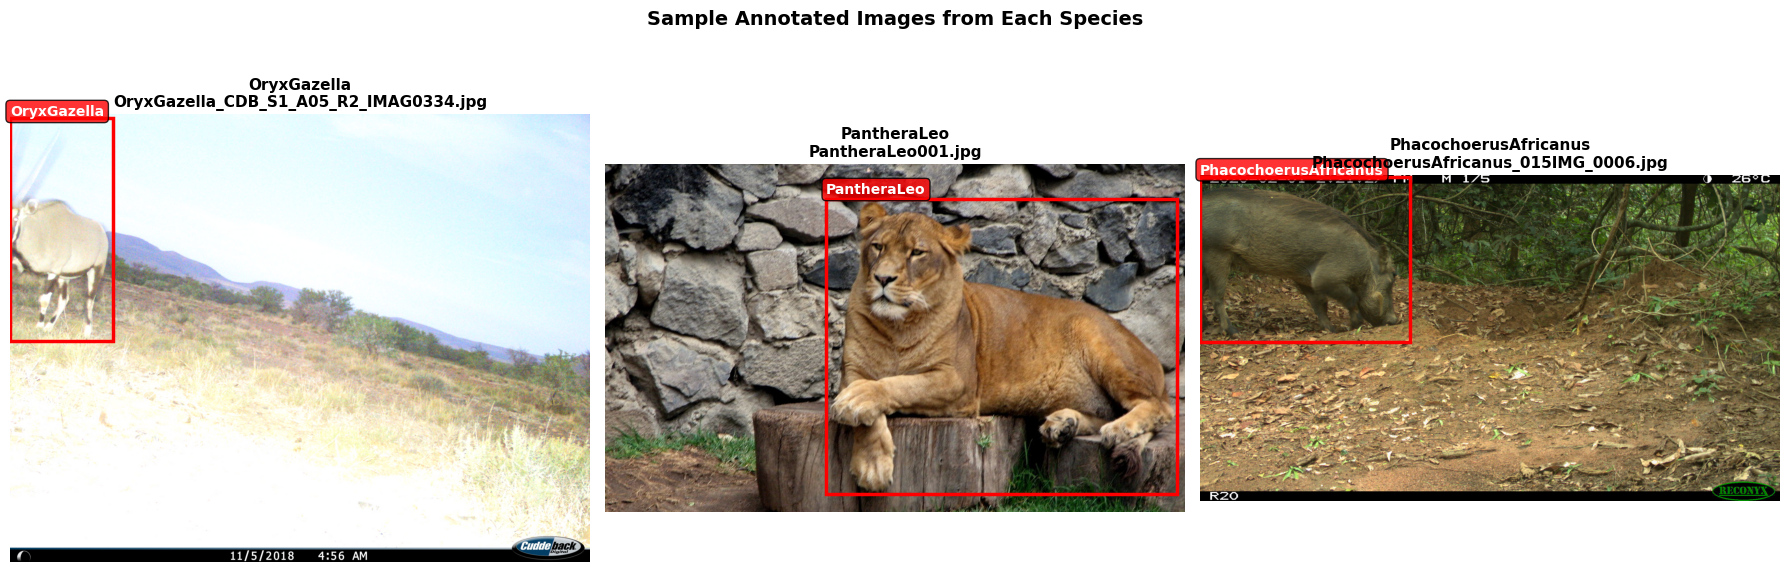

In [10]:
# Visualizing sample annotated images
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

# we will Select one sample image per class
sample_images = {}
for class_name in ['OryxGazella', 'PantheraLeo', 'PhacochoerusAfricanus']:
    for xml_file in os.listdir(TRAIN_ANN_DIR):
        if not xml_file.endswith('.xml'):
            continue
        tree = ET.parse(os.path.join(TRAIN_ANN_DIR, xml_file))
        root = tree.getroot()
        
        # Check if this XML contains the target class
        for obj in root.findall('object'):
            if obj.find('name').text.strip() == class_name:
                img_filename = root.find('filename').text.strip()
                sample_images[class_name] = (img_filename, xml_file)
                break
        if class_name in sample_images:
            break

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (class_name, (img_file, xml_file)) in enumerate(sample_images.items()):
    # Load and display the image
    img_path = os.path.join(TRAIN_IMG_DIR, img_file)
    img = Image.open(img_path)
    axes[idx].imshow(img)
    
    # Parse XML and draw all bounding boxes
    tree = ET.parse(os.path.join(TRAIN_ANN_DIR, xml_file))
    root = tree.getroot()
    
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        
        # Draw rectangle
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                 linewidth=2.5, edgecolor='red', facecolor='none')
        axes[idx].add_patch(rect)
        
        # Add class label
        label_text = obj.find('name').text.strip()
        axes[idx].text(xmin, ymin-10, label_text, 
                      bbox=dict(boxstyle='round', facecolor='red', alpha=0.8),
                      fontsize=10, color='white', weight='bold')
    
    axes[idx].set_title(f'{class_name}\n{img_file}', fontsize=11, weight='bold')
    axes[idx].axis('off')

plt.suptitle('Sample Annotated Images from Each Species', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

The sample images confirm annotation quality, with tight bounding boxes accurately localizing each animal. Visual inspection validates the species-specific characteristics identified in the earlier bbox analysis, including body shape differences and scale variation across camera trap conditions.

## Image Resolution Analysis

This section analyses the height and width of images in the dataset to understand
their resolution distribution prior to model training.

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

dim1 = []  # heights
dim2 = []  # widths

for image_file in os.listdir(IMAGES_DIR):
    name, ext = os.path.splitext(image_file)
    
    if ext.lower() in [".jpg", ".jpeg", ".png"]:
        try:
            img = imread(os.path.join(IMAGES_DIR, image_file))
            
            # Handle RGB and grayscale images
            if len(img.shape) == 2:
                h, w = img.shape
            else:
                h, w, _ = img.shape
            
            dim1.append(h)
            dim2.append(w)
            
        except:
            print("Skipped:", image_file)


In [12]:
len(dim1)

1536

In [13]:
print("Mean height:", np.mean(dim1))
print("Min height:", np.min(dim1), "Max height:", np.max(dim1))

print("Mean width:", np.mean(dim2))
print("Min width:", np.min(dim2), "Max width:", np.max(dim2))


Mean height: 1396.0592447916667
Min height: 408 Max height: 2448
Mean width: 1877.833984375
Min width: 485 Max width: 3264


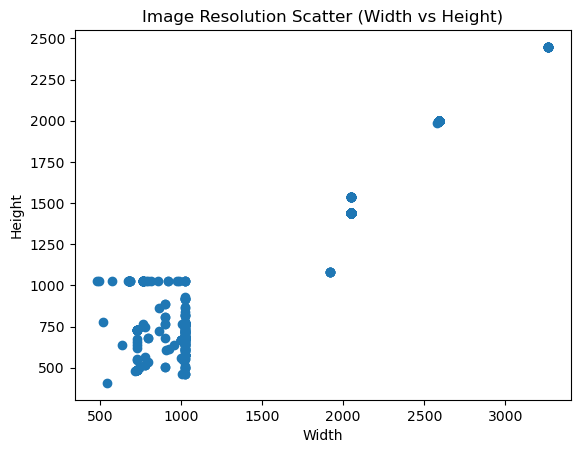

In [14]:
plt.figure()
plt.scatter(dim2, dim1)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Scatter (Width vs Height)")
plt.show()


**Resolution Variability:** Image dimensions vary considerably (height: 408-2448px, width: 485-3264px, mean: 1396×1878px), typical of camera trap data. The TensorFlow Object Detection API handles this automatically by resizing inputs to a fixed dimension (configured during training) while maintaining aspect ratio through padding. The relatively high mean resolution (>1MP) is beneficial for capturing fine-grained species-distinguishing features.

## Data Augmentation Strategy

To improve model generalisation with approximately 500 images per class, a lightweight augmentation strategy will be applied during training via the TensorFlow Object Detection API pipeline configuration.

- Random horizontal flip
- Random hue adjustment
- Random contrast adjustment
- Random saturation adjustment
- Random square crop by scale (0.6–1.3)

These Augmentations were applied during training via the pipeline configuration. This augmentation strategy reflects common camera trap variation (viewpoint and lighting) while preserving biological realism and annotation integrity.

## Train/Test Split Strategy

The dataset was split into 90% training and 10% testing, resulting in 1,383 training images and 153 test images. This split provides sufficient test samples per class for reliable evaluation while maximising the amount of data available for model training. Given the relatively balanced class distribution across species, a simple random split was used, as it is sufficient to preserve approximate class balance without requiring explicit stratification.

In [15]:
import os

BASE_SPLIT_DIR = "data_split"
TRAIN_IMG_DIR = os.path.join(BASE_SPLIT_DIR, "train", "images")
TRAIN_ANN_DIR = os.path.join(BASE_SPLIT_DIR, "train", "annotations")
TEST_IMG_DIR  = os.path.join(BASE_SPLIT_DIR, "test", "images")
TEST_ANN_DIR  = os.path.join(BASE_SPLIT_DIR, "test", "annotations")

os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(TRAIN_ANN_DIR, exist_ok=True)
os.makedirs(TEST_IMG_DIR, exist_ok=True)
os.makedirs(TEST_ANN_DIR, exist_ok=True)

print("Train/Test directories created")

Train/Test directories created


### Generate split lists

A random 10% of annotated images are assigned to the test set, with the remaining
90% used for training. A fixed random seed is used to make the split reproducible.

In [16]:
import random

# Build list of image files (only those with matching XML)
image_files = []
for f in os.listdir(IMAGES_DIR):
    name, ext = os.path.splitext(f)
    if ext.lower() in [".jpg", ".jpeg", ".png"]:
        xml_path = os.path.join(ANNOTATIONS_DIR, name + ".xml")
        if os.path.exists(xml_path):
            image_files.append(f)

print("Total image+XML pairs found:", len(image_files))

# Reproducible split
random.seed(42)
random.shuffle(image_files)

test_size = int(0.10 * len(image_files))
test_files = image_files[:test_size]
train_files = image_files[test_size:]

print("Train files:", len(train_files))
print("Test files:", len(test_files))


Total image+XML pairs found: 1536
Train files: 1383
Test files: 153


### Create train and test datasets

Images and their corresponding XML annotation files are copied into the
appropriate train and test directories based on the generated split lists.

In [33]:
import shutil

# Copy training files
for f in train_files:
    name, ext = os.path.splitext(f)
    
    shutil.copy(
        os.path.join(IMAGES_DIR, f),
        os.path.join(TRAIN_IMG_DIR, f)
    )
    
    shutil.copy(
        os.path.join(ANNOTATIONS_DIR, name + ".xml"),
        os.path.join(TRAIN_ANN_DIR, name + ".xml")
    )

# Copy testing files
for f in test_files:
    name, ext = os.path.splitext(f)
    
    shutil.copy(
        os.path.join(IMAGES_DIR, f),
        os.path.join(TEST_IMG_DIR, f)
    )
    
    shutil.copy(
        os.path.join(ANNOTATIONS_DIR, name + ".xml"),
        os.path.join(TEST_ANN_DIR, name + ".xml")
    )

print("Train/Test split completed")


Train/Test split completed


In [18]:
len(os.listdir(TRAIN_IMG_DIR)), len(os.listdir(TEST_IMG_DIR))

(1383, 153)

The dataset has been successfully partitioned into training and testing subsets.
Images and annotation files are kept paired to ensure consistency during model
training and evaluation.

### Verify class distribution in train/test splits

In [19]:
import os

# Training data
TRAIN_IMG_DIR = r"C:\Users\MSC1\data_split\train\images"
TRAIN_ANN_DIR = r"C:\Users\MSC1\data_split\train\annotations"

# Test data
TEST_IMG_DIR  = r"C:\Users\MSC1\data_split\test\images"
TEST_ANN_DIR  = r"C:\Users\MSC1\data_split\test\annotations"

# checks 
assert os.path.isdir(TRAIN_IMG_DIR), f"Missing: {TRAIN_IMG_DIR}"
assert os.path.isdir(TRAIN_ANN_DIR), f"Missing: {TRAIN_ANN_DIR}"
assert os.path.isdir(TEST_ANN_DIR),  f"Missing: {TEST_ANN_DIR}"

print("Directories loaded correctly")


Directories loaded correctly


In [20]:
train_class_dist = {}
test_class_dist = {}

for xml_file in os.listdir(TRAIN_ANN_DIR):
    if not xml_file.endswith('.xml'):
        continue
    tree = ET.parse(os.path.join(TRAIN_ANN_DIR, xml_file))
    root = tree.getroot()
    
    img_filename = root.find('filename').text.strip()
    for obj in root.findall('object'):
        class_name = obj.find('name').text.strip()
        if img_filename not in train_class_dist:
            train_class_dist[img_filename] = set()
        train_class_dist[img_filename].add(class_name)

for xml_file in os.listdir(TEST_ANN_DIR):
    if not xml_file.endswith('.xml'):
        continue
    tree = ET.parse(os.path.join(TEST_ANN_DIR, xml_file))
    root = tree.getroot()
    
    img_filename = root.find('filename').text.strip()
    for obj in root.findall('object'):
        class_name = obj.find('name').text.strip()
        if img_filename not in test_class_dist:
            test_class_dist[img_filename] = set()
        test_class_dist[img_filename].add(class_name)

# Count images per class (images may contain multiple classes)
train_counts = {}
test_counts = {}

for img, classes in train_class_dist.items():
    for class_name in classes:
        train_counts[class_name] = train_counts.get(class_name, 0) + 1

for img, classes in test_class_dist.items():
    for class_name in classes:
        test_counts[class_name] = test_counts.get(class_name, 0) + 1

print("\n" + "="*65)
print("TRAIN/TEST SPLIT VERIFICATION")
print("="*65)
print(f"{'Species':<28} {'Train':<12} {'Test':<12} {'Test %':<10}")
print("-"*65)
for class_name in sorted(train_counts.keys()):
    train_count = train_counts.get(class_name, 0)
    test_count = test_counts.get(class_name, 0)
    test_pct = (test_count / (train_count + test_count)) * 100 if (train_count + test_count) > 0 else 0
    print(f"{class_name:<28} {train_count:<12} {test_count:<12} {test_pct:<10.1f}%")
print("="*65)


TRAIN/TEST SPLIT VERIFICATION
Species                      Train        Test         Test %    
-----------------------------------------------------------------
OryxGazella                  462          42           8.3       %
PantheraLeo                  465          60           11.4      %
PhacochoerusAfricanus        456          51           10.1      %


### Split Quality Check
Class distribution is maintained across splits (test %: 8.3-11.4%), confirming random splitting was sufficient given the balanced dataset. Image-level splitting prevents data leakage, ensuring true model evaluation on unseen data.

## TFRecord Generation

TFRecords provide efficient data loading for the TensorFlow Object Detection API. Prior to conversion, XML annotations were sanitized to ensure class name consistency, filename matching, and valid bounding box coordinates.

This section checks that the TFRecord generation script is available locally before creating train/test TFRecord files.

In [21]:
import os

SEARCH_ROOT = r"C:\Users\MSC1\Desktop\Tensorflow-Object-Detection-API"

targets = {"generate_tfrecord.py", "generate_tfrecord.py.py", "create_tfrecord.py"}

found = []
for root, dirs, files in os.walk(SEARCH_ROOT):
    for t in targets:
        if t in files:
            found.append(os.path.join(root, t))

found

['C:\\Users\\MSC1\\Desktop\\Tensorflow-Object-Detection-API\\Base\\v1\\object_detection\\generate_tfrecord.py']

## Label Map

A label map is required by the TF2 Object Detection API to map each class name
to a numeric ID used during training and evaluation.

In [22]:
LABEL_MAP_PATH = "label_map.pbtxt"
LABEL_MAP_PATH

'label_map.pbtxt'

The three selected classes are assigned IDs from 1 to 3. These IDs must remain
consistent across TFRecord generation, training, evaluation and inference.

In [23]:
label_map_text = """item {
  id: 1
  name: 'OryxGazella'
}
item {
  id: 2
  name: 'PantheraLeo'
}
item {
  id: 3
  name: 'PhacochoerusAfricanus'
}
"""

with open(LABEL_MAP_PATH, "w") as f:
    f.write(label_map_text)

print("Saved:", LABEL_MAP_PATH)


Saved: label_map.pbtxt


In [24]:
!type label_map.pbtxt

item {
  id: 1
  name: 'OryxGazella'
}
item {
  id: 2
  name: 'PantheraLeo'
}
item {
  id: 3
  name: 'PhacochoerusAfricanus'
}


## Generate TFRecord Files

TFRecord files are created for the training and testing datasets. TFRecords are the
recommended input format for the TF2 Object Detection API and improve data loading
performance during training and evaluation.

In [39]:
TFRECORD_SCRIPT = r"C:\Users\MSC1\Desktop\Tensorflow-Object-Detection-API\Base\v1\object_detection\generate_tfrecord.py"

TRAIN_IMG_DIR = r"C:\Users\MSC1\data_split\train\images"
TRAIN_ANN_DIR = r"C:\Users\MSC1\data_split\train\annotations"
TEST_IMG_DIR  = r"C:\Users\MSC1\data_split\test\images"
TEST_ANN_DIR  = r"C:\Users\MSC1\data_split\test\annotations"

TRAIN_RECORD = r"C:\Users\MSC1\data_split\train.record"
TEST_RECORD  = r"C:\Users\MSC1\data_split\test.record"

The TFRecord generation is performed separately for the training and test subsets
to be sure that evaluation is carried out on unseen data only.

## XML Cleaning

All XML annotations contained whitespace in 'name' and 'filename' fields caused by formatting from the annotation tool. These were cleaned to match label map class names and actual image filenames

In [40]:
import os
import xml.etree.ElementTree as ET

def sanitize_xml_directory(xml_dir):
    fixed_count = 0
    for xml_file in os.listdir(xml_dir):
        if not xml_file.endswith('.xml'):
            continue
        
        path = os.path.join(xml_dir, xml_file)
        tree = ET.parse(path)
        root = tree.getroot()
        changed = False
        
        # Fixing filename field
        fn_node = root.find("filename")
        if fn_node is not None and fn_node.text:
            fn_node.text = fn_node.text.strip()
            changed = True
        
        # Fixing class names
        for obj in root.findall("object"):
            name_node = obj.find("name")
            if name_node is not None and name_node.text:
                name_node.text = name_node.text.strip()
                changed = True
        
        if changed:
            tree.write(path)
            fixed_count += 1
    
    return fixed_count

train_fixed = sanitize_xml_directory(TRAIN_ANN_DIR)
test_fixed = sanitize_xml_directory(TEST_ANN_DIR)

print(f"XML Sanitization Complete:")
print(f"  Train: {train_fixed} files")
print(f"  Test: {test_fixed} files")

XML Sanitization Complete:
  Train: 1383 files
  Test: 153 files


In [41]:
!python "{TFRECORD_SCRIPT}" -x "{TRAIN_ANN_DIR}" -i "{TRAIN_IMG_DIR}" -l "{LABEL_MAP_PATH}" -o "{TRAIN_RECORD}"

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'
Successfully created the TFRecord file: C:\Users\MSC1\data_split\train.record


C:\Users\MSC1\anaconda3\envs\Env-7144COMP\lib\site-packages\google\api_core\_python_version_support.py:237: FutureWarning: You are using a non-supported Python version (3.8.16). Google will not post any further updates to google.api_core supporting this Python version. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


The training TFRecord (`train.record`) was generated successfully and will be used as the
input dataset for training the object detection models in the training notebook.

In [43]:
!python "{TFRECORD_SCRIPT}" -x "{TEST_ANN_DIR}" -i "{TEST_IMG_DIR}" -l "{LABEL_MAP_PATH}" -o "{TEST_RECORD}"

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'
Successfully created the TFRecord file: C:\Users\MSC1\data_split\test.record


C:\Users\MSC1\anaconda3\envs\Env-7144COMP\lib\site-packages\google\api_core\_python_version_support.py:237: FutureWarning: You are using a non-supported Python version (3.8.16). Google will not post any further updates to google.api_core supporting this Python version. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


The test TFRecord (`test.record`) was generated successfully and will be used only for
evaluation on unseen data to measure generalisation performance.

## TFRecord Output Check

This section confirms that the TFRecord files have been generated successfully
and are available for model training and evaluation.

In [47]:
import os

TRAIN_RECORD = r"C:\Users\MSC1\data_split\train.record"
TEST_RECORD  = r"C:\Users\MSC1\data_split\test.record"

print("train.record exists:", os.path.exists(TRAIN_RECORD), "size:", os.path.getsize(TRAIN_RECORD))
print("test.record exists:", os.path.exists(TEST_RECORD), "size:", os.path.getsize(TEST_RECORD))

train.record exists: True size: 1019095588
test.record exists: True size: 108466753


In [49]:
# Verifying TFRecord content
import tensorflow as tf

TRAIN_RECORD = r"C:\Users\MSC1\data_split\train.record"  # <-- use your real output path

def parse_tfrecord(example):
    feature_description = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/filename": tf.io.FixedLenFeature([], tf.string),
        "image/object/class/text": tf.io.VarLenFeature(tf.string),
    }
    return tf.io.parse_single_example(example, feature_description)

dataset = tf.data.TFRecordDataset(TRAIN_RECORD)

first_record = next(iter(dataset))
parsed = parse_tfrecord(first_record)

filename = parsed["image/filename"].numpy().decode("utf-8")
classes = [c.decode("utf-8") for c in parsed["image/object/class/text"].values.numpy()]
img_bytes = len(parsed["image/encoded"].numpy())

print("\nTFRecord Content Validation:")
print("  Filename:", filename)
print("  Classes:", classes)
print("  Encoded image bytes:", img_bytes)
print("\n TFRecord contains valid data and is ready for training.")



TFRecord Content Validation:
  Filename: OryxGazella_CDB_S1_A05_R2_IMAG0334.jpg
  Classes: ['OryxGazella']
  Encoded image bytes: 595366

 TFRecord contains valid data and is ready for training.


In [50]:
print("Total examples (train):", sum(1 for _ in tf.data.TFRecordDataset(TRAIN_RECORD)))

Total examples (train): 1383


### TFRecord Validation Results
File size and content inspection confirm successful TFRecord generation. Both train and test files contain valid serialized images, bounding boxes, and class labels ready for the TensorFlow Object Detection API.

## Dataset Limitations

Key limitations include:
- **Scale:** ~500-660 images per class - mitigated via transfer learning and augmentation
- **Viewpoint:** Fixed camera trap perspectives - model specialized for this deployment context
- **Annotation:** Single annotator ensures consistency but may introduce systematic bias

These constraints are acknowledged when interpreting model performance.

## Preprocessing Summary

All Task 1 requirements completed:
- Three species annotated (504-661 images per class, >500 minimum met)
- Comprehensive EDA: class distribution, bbox analysis, resolution assessment
- 90/10 train/test split with validation (1383/153 images)
- TFRecords generated and verified (train: 1.0GB, test: 108MB)
- Augmentation strategy defined for training pipeline

Dataset prepared for model training.